### Import library

In [23]:
import cv2
import os
import numpy as np
import pandas as pd
import joblib
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from sklearn.model_selection import GridSearchCV

### Fungsi untuk mengonversi waktu dalam format mmss (misalnya 0015 -> 00:15) menjadi detik

In [24]:
def ConvertTime(time):
    time = time.strip()
    minutes = time[:2]
    seconds = time[2:]
    minutes = int(minutes)
    seconds = int(seconds)
    return minutes * 60 + seconds


### Fungsi untuk memuat data ground truth dari gt.txt untuk proses splitting. Mengembalikan list [start_time_sec, end_time_sec, cheating_type]

In [ ]:
def LoadGTData(GTPath):
    GTList = []
    with open(GTPath, 'r') as f:
        lines = f.readlines()
        for line in enumerate(lines, 1):
            parts = line.strip().split("\t")
            if len(parts) == 3:
                start, end, cheating = parts[0], parts[1], parts[2]
                start = ConvertTime(start)
                end = ConvertTime(end)

                if start is not None and end is not None:
                    cheating = int(cheating)
                    GTList.append([start, end, cheating])
    return GTList

### Fungsi untuk mengekstrak frame dari segmen video dan menyimpannya. fps_video bisa di-pass jika sudah diketahui untuk efisiensi.
sumber : https://thepythoncode.com/article/extract-frames-from-videos-in-python

In [ ]:
def ExtractFrames(VideoPath, StartSec, EndSec, OutputPath, fps):
    FramesCount = 0
    cap = cv2.VideoCapture(VideoPath)
    if not cap.isOpened():
        return FramesCount
    if fps is None or fps <= 0:
        cap.release()
        return FramesCount
    VideoFrames = cap.get(cv2.CAP_PROP_FRAME_COUNT)
    VideoSecond = VideoFrames / fps if fps > 0 else 0
    
    StartSec = max(0, StartSec)
    EndSec = min(EndSec, VideoSecond)
    if StartSec >= EndSec:
        cap.release()
        return FramesCount
        
    StartFrame = int(fps * StartSec)
    EndFrame = int(fps * EndSec)
    EndFrame = min(EndFrame, int(VideoFrames) - 1) 
    StartFrame = max(0, StartFrame) 
    if StartFrame > EndFrame:
        cap.release()
        return FramesCount
    cap.set(cv2.CAP_PROP_POS_FRAMES, StartFrame)
    
    for _ in range(StartFrame, EndFrame + 1): 
        ret, frame = cap.read()
        if ret:
            FrameName = os.path.join(OutputPath, f"frame_{FramesCount:04d}.jpg")
            cv2.imwrite(FrameName, frame)
            FramesCount += 1
        else:
            break 
    
    cap.release()
    return FramesCount

### Fungsi untuk memproses semua video subjek, membaginya menjadi frame berdasarkan gt.txt.

In [ ]:
def SplitToFrame(
        BasePath, 
        FrameOutputPath, 
        NonCheatingLabel=0,
        MaxFrame=1000, 
        Interval=2 
    ):

    SubjectFolder = [f for f in os.listdir(BasePath) if os.path.isdir(os.path.join(BasePath, f))]

    VideoName = {
        "subject10": "huangpi21.avi", "subject11": "alhashe31.avi",
        "subject12": "makiluke1.avi", "subject13": "guolingh1.avi",
        "subject14": "chuangy61.avi", "subject15": "bajajpak1.avi",
        "subject16": "dhingra51.avi", "subject17": "zhoulian1.avi",
        "subject18": "yuqianyi1.avi", "subject19": "wangyus11.avi"
    }

    for SubjectName in SubjectFolder:
        if SubjectName not in VideoName:
            continue

        SubjectPath = os.path.join(BasePath, SubjectName)
        GTPath = os.path.join(SubjectPath, "gt.txt")
        VideoPath = os.path.join(SubjectPath, VideoName[SubjectName])

        cap = cv2.VideoCapture(VideoPath)
        fps = cap.get(cv2.CAP_PROP_FPS)
        TotalFrame = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        DurationVideo = TotalFrame / fps
        cap.release()

        OutputFrameSubject = os.path.join(FrameOutputPath, SubjectName)
        os.makedirs(OutputFrameSubject, exist_ok=True)

        CheatingSegment = LoadGTData(GTPath)

        for start, end, tipe in CheatingSegment:
            FolderName = f"segment_{start}{end}{tipe}"
            SegmentPath = os.path.join(OutputFrameSubject, FolderName)
            os.makedirs(SegmentPath, exist_ok=True)
            ExtractFrames(VideoPath, start, end, SegmentPath, fps)

        SegmentNonCheating = []
        CheatingSegment.sort(key=lambda x: x[0])

        last = 0
        for start, end, _ in CheatingSegment:
            if start > last:
                SegmentNonCheating.append((last, start))
            last = max(last, end)
        if last < DurationVideo:
            SegmentNonCheating.append((last, DurationVideo))
        if not CheatingSegment:
            SegmentNonCheating.append((0, DurationVideo))

        ExtractedFrame = 0
        for startnc, endnc in SegmentNonCheating:
            CurrentTime = startnc
            while CurrentTime < endnc and ExtractedFrame < MaxFrame:
                StartFolder = int(CurrentTime)
                EndFolder = int(CurrentTime + 0.1)
                FolderNamenc = f"segment_{StartFolder}{EndFolder}{NonCheatingLabel}"
                SegmentPathnc = os.path.join(OutputFrameSubject, FolderNamenc)
                os.makedirs(SegmentPathnc, exist_ok=True)

                cap = cv2.VideoCapture(VideoPath)
                cap.set(cv2.CAP_PROP_POS_MSEC, CurrentTime * 1000)
                ret, frame = cap.read()
                cap.release()
                if ret:
                    frame_filename = os.path.join(SegmentPathnc, f"frame_0000.jpg")
                    cv2.imwrite(frame_filename, frame)
                    ExtractedFrame += 1

                CurrentTime += Interval

### Fungsi equalisasi histogram

In [ ]:
def ExtractColorHistogram(Image, BinsPerChannel=8, ResizeDim=None):
    if ResizeDim: ImageResized = cv2.resize(Image, ResizeDim)
    else: ImageResized = Image
    if ImageResized.shape[0] == 0 or ImageResized.shape[1] == 0: return np.zeros(BinsPerChannel**3)
    
    HSVImage = cv2.cvtColor(ImageResized, cv2.COLOR_BGR2HSV)
    HChannel, SChannel, VChannel = cv2.split(HSVImage)
    
    Hrange, SRange, VRange = (0, 180), (0, 256), (0, 256)
    Hist3D = np.zeros((BinsPerChannel, BinsPerChannel, BinsPerChannel), dtype=np.float32)

    HBinWidth = Hrange[1] / BinsPerChannel if BinsPerChannel > 0 else float('inf')
    SBinWidth = SRange[1] / BinsPerChannel if BinsPerChannel > 0 else float('inf')
    VBinWidth = VRange[1] / BinsPerChannel if BinsPerChannel > 0 else float('inf')
    
    if BinsPerChannel <= 0: return np.zeros(0) 

    for RIndex in range(HSVImage.shape[0]):
        for CIndex in range(HSVImage.shape[1]):
            HVal, SVal, VVal = HChannel[RIndex, CIndex], SChannel[RIndex, CIndex], VChannel[RIndex, CIndex]

            HBin = min(int(HVal / HBinWidth), BinsPerChannel - 1) if HBinWidth != float('inf') else 0
            SBin = min(int(SVal / SBinWidth), BinsPerChannel - 1) if SBinWidth != float('inf') else 0
            VBin = min(int(VVal / VBinWidth), BinsPerChannel - 1) if VBinWidth != float('inf') else 0
            
            Hist3D[HBin, SBin, VBin] += 1
            
    HistFlat = Hist3D.flatten()
    SumHistFlat = HistFlat.sum()
    if SumHistFlat > 0:
        HistNormalized = HistFlat / SumHistFlat
    else:
        HistNormalized = HistFlat 
        
    return HistNormalized

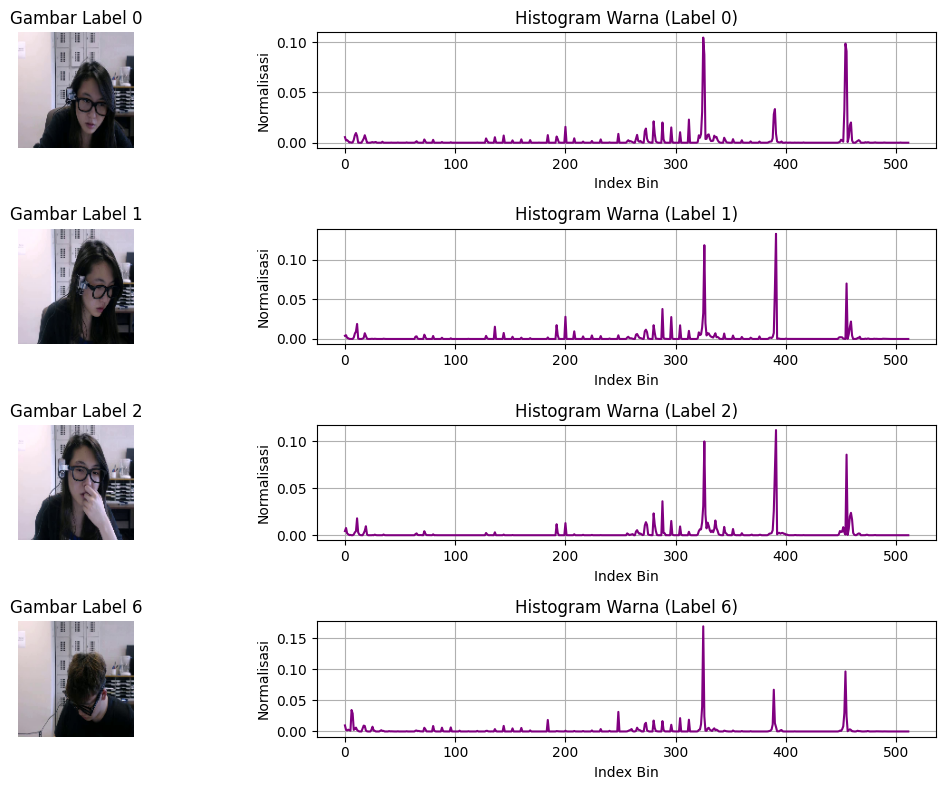

In [ ]:
ImagePath = {
    0: "frame_0000.jpg",
    1: "frame_0061.jpg",
    2: "frame_0002.jpg",
    6: "frame_0006.jpg" 
}

ResizeDim = (128, 128)
Bins = 8

plt.figure(figsize=(12, 8))
for Index, (Label, Path) in enumerate(ImagePath.items()):
    Image = cv2.imread(Path)
    Histogram = ExtractColorHistogram(Image, BinsPerChannel=Bins, ResizeDim=ResizeDim)
    ImageResized = cv2.resize(Image, ResizeDim)

    plt.subplot(4, 2, 2*Index + 1)
    plt.imshow(cv2.cvtColor(ImageResized, cv2.COLOR_BGR2RGB))
    plt.title(f"Gambar Label {Label}")
    plt.axis('off')
    
    plt.subplot(4, 2, 2*Index + 2)
    plt.plot(Histogram, color='purple')
    plt.title(f"Histogram Warna (Label {Label})")
    plt.xlabel("Index Bin")
    plt.ylabel("Normalisasi")
    plt.grid(True)

plt.tight_layout()
plt.show()

### HOG descriptor
sumber : https://github.com/danielshaving/CV_Features_HoG_Feature_Extraction

In [17]:
class HOGDescriptor():
    def __init__(self, Image, CellSize=8, BinSize=9):
        ImageNorm = np.sqrt(Image / float(np.max(Image) + 1e-7)) 
        self.Image = ImageNorm * 255
        self.CellSize = CellSize
        self.BinSize = BinSize
        self.AngleUnit = 180.0 / self.BinSize 
        assert type(self.BinSize) == int, "BinSize should be integer,"
        assert type(self.CellSize) == int, "CellSize should be integer,"

    def ExtractHOG(self):
        Height, Width = self.Image.shape
        if Height < self.CellSize * 2 or Width < self.CellSize * 2 : 
            return np.array([])

        gx = cv2.Sobel(self.Image, cv2.CV_64F, 1, 0, ksize=1) 
        gy = cv2.Sobel(self.Image, cv2.CV_64F, 0, 1, ksize=1)
        GradientMagnitude, GradientAngleDegree = cv2.cartToPolar(gx, gy, angleInDegrees=True)
        GradientAngleDegree = GradientAngleDegree % 180.0
        
        NumY = int(Height / self.CellSize)
        NumX = int(Width / self.CellSize)
        CellHistogram = np.zeros((NumY, NumX, self.BinSize))

        for i in range(NumY):
            for j in range(NumX):
                CellMagnitude = GradientMagnitude[i * self.CellSize:(i + 1) * self.CellSize,
                                             j * self.CellSize:(j + 1) * self.CellSize]
                CellAngleDegree = GradientAngleDegree[i * self.CellSize:(i + 1) * self.CellSize,
                                             j * self.CellSize:(j + 1) * self.CellSize]
                CellHistogram[i, j, :] = self.CellGradientHistogram(CellMagnitude, CellAngleDegree)
        
        HOGFeatures = []
        for i in range(NumY - 1): 
            for j in range(NumX - 1): 
                BlockVector = np.concatenate((
                    CellHistogram[i, j, :],
                    CellHistogram[i, j + 1, :],
                    CellHistogram[i + 1, j, :],
                    CellHistogram[i + 1, j + 1, :]
                ))
                
                Normalize = np.sqrt(np.sum(BlockVector**2) + 1e-5) 
                if Normalize > 0:
                    BlockVectorNorm = BlockVector / Normalize
                    BlockVectorNorm = np.minimum(BlockVectorNorm, 0.2)
                    NormClipped = np.sqrt(np.sum(BlockVectorNorm**2) + 1e-5) 
                    if NormClipped > 0 :
                        BlockVectorNorm = BlockVectorNorm / NormClipped
                else:
                    BlockVectorNorm = np.zeros_like(BlockVector)
                
                HOGFeatures.extend(BlockVectorNorm)
        
        return np.array(HOGFeatures).flatten()

    def CellGradientHistogram(self, CellMagnitude, CellAngleDegree):
        OrientationHist = np.zeros(self.BinSize, dtype=np.float32)
        for RIndex in range(CellMagnitude.shape[0]):
            for CIndex in range(CellMagnitude.shape[1]):
                Magnitude = CellMagnitude[RIndex, CIndex]
                Angle = CellAngleDegree[RIndex, CIndex]
                Angle = max(0, min(Angle, 180.0 - 1e-5))
                
                BinIndexLowFloat = Angle / self.AngleUnit
                FirstBinIndex = int(np.floor(BinIndexLowFloat))

                Factor = BinIndexLowFloat - FirstBinIndex

                b1 = FirstBinIndex % self.BinSize
                b2 = (FirstBinIndex + 1) % self.BinSize 

                OrientationHist[b1] += Magnitude * (1 - Factor)
                OrientationHist[b2] += Magnitude * Factor
        return OrientationHist

### Fungsi fitur HOG

In [18]:
def ExtractHOGFeatures(Image, ResizeDim=(64,128), CellSize=8, BinSize=9):
    if ResizeDim: ImageRisezed = cv2.resize(Image, ResizeDim)
    else: ImageRisezed = Image
    MinDimY = CellSize * 2 
    MinDimX = CellSize * 2
    if ImageRisezed.shape[0] < MinDimY or ImageRisezed.shape[1] < MinDimX :
        NumCellsYIdeal = ResizeDim[1] // CellSize
        NumCellsXIdeal = ResizeDim[0] // CellSize
        NumBlockYIdeal = NumCellsYIdeal - 1
        NumBlockXIdeal = NumCellsXIdeal - 1
        ExcpectedLen = 0
        if NumBlockYIdeal > 0 and NumBlockXIdeal > 0:
            ExcpectedLen = NumBlockYIdeal * NumBlockXIdeal * BinSize * 4
        return np.zeros(ExcpectedLen) 
        
    GrayImage = cv2.cvtColor(ImageRisezed, cv2.COLOR_BGR2GRAY)
    HOGCalc = HOGDescriptor(GrayImage, CellSize=CellSize, BinSize=BinSize)
    HOGVector = HOGCalc.ExtractHOG() 
    return HOGVector

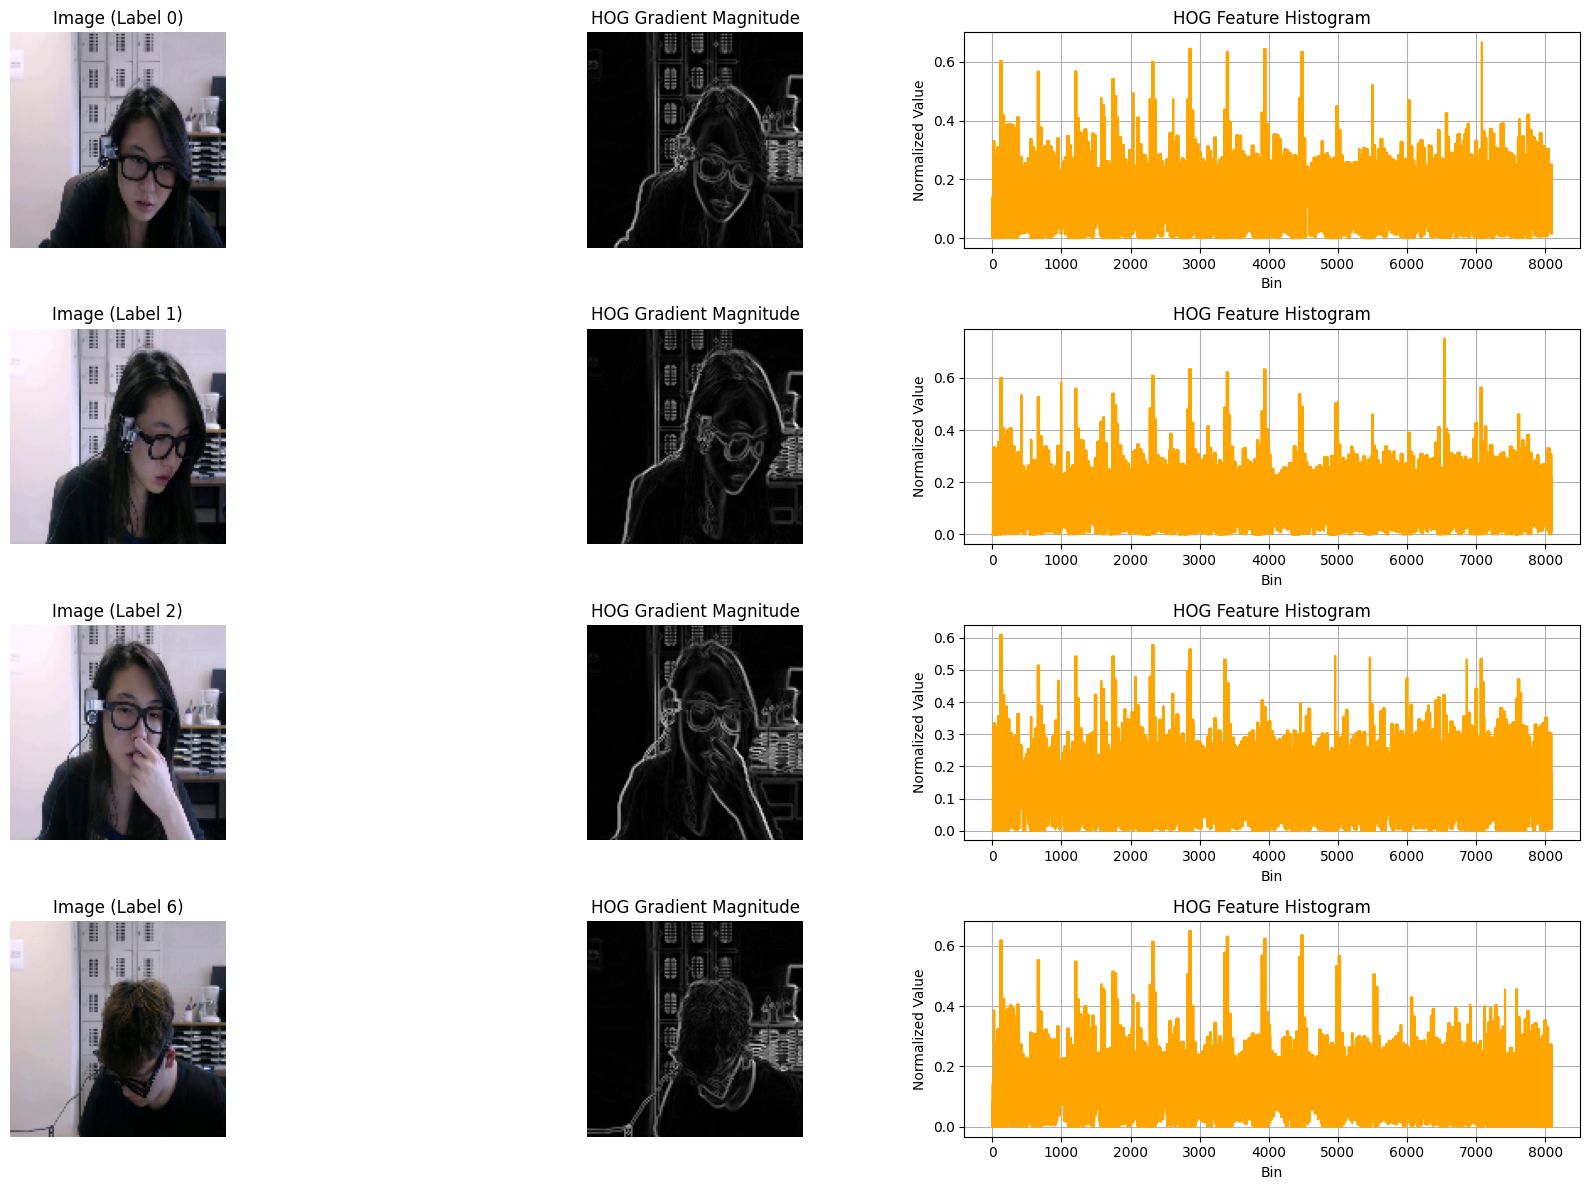

In [20]:
ImagePath = {
    0: "frame_0000.jpg",
    1: "frame_0061.jpg",
    2: "frame_0002.jpg",
    6: "frame_0006.jpg"
}

def HOGVisualize(Image):
    Gray = cv2.cvtColor(Image, cv2.COLOR_BGR2GRAY)
    gx = cv2.Sobel(Gray, cv2.CV_32F, 1, 0, ksize=1)
    gy = cv2.Sobel(Gray, cv2.CV_32F, 0, 1, ksize=1)
    Magnitude, _ = cv2.cartToPolar(gx, gy, angleInDegrees=True)
    return Magnitude

plt.figure(figsize=(18, 12))
for Index, (Label, Path) in enumerate(ImagePath.items()):
    Image = cv2.imread(Path)
    ImageResized = cv2.resize(Image, (128, 128))

    HOGVector = ExtractHOGFeatures(Image, ResizeDim= (128, 128))

    plt.subplot(len(ImagePath), 3, Index * 3 + 1)
    plt.imshow(cv2.cvtColor(ImageResized, cv2.COLOR_BGR2RGB))
    plt.title(f"Image (Label {Label})")
    plt.axis('off')

    Magnitude = HOGVisualize(ImageResized)
    plt.subplot(len(ImagePath), 3, Index * 3 + 2)
    plt.imshow(Magnitude, cmap='gray')
    plt.title("HOG Gradient Magnitude")
    plt.axis('off')

    plt.subplot(len(ImagePath), 3, Index * 3 + 3)
    plt.plot(HOGVector, color='orange')
    plt.title("HOG Feature Histogram")
    plt.xlabel("Bin")
    plt.ylabel("Normalized Value")
    plt.grid(True)

plt.tight_layout()
plt.show()

### Fungsi fitur LBP
sumber : https://www.geeksforgeeks.org/create-local-binary-pattern-of-an-image-using-opencv-python/

In [21]:
def LBPGetPixel(ImageGray, CenterValue, r, c):
    PixelValue = 0
    try:
        if ImageGray[r, c] >= CenterValue: PixelValue = 1
    except IndexError: pass
    return PixelValue

def LBPCalculatePixel(ImageGray, r_center, c_center):
    CenterValue = ImageGray[r_center, c_center]
    BinaryCodeList = []
    NeighborsOffset = [(-1, -1), (-1, 0), (-1, 1), (0, 1), (1, 1), (1, 0), (1, -1), (0, -1)]
    for dr, dc in NeighborsOffset:
        BinaryCodeList.append(LBPGetPixel(ImageGray, CenterValue, r_center + dr, c_center + dc))
    Decimalvalue = 0
    Kuadrat2 = [1, 2, 4, 8, 16, 32, 64, 128]
    for i in range(len(BinaryCodeList)): Decimalvalue += BinaryCodeList[i] * Kuadrat2[i]
    return Decimalvalue

def LBPExtractFeatures(Image, ResizeDim=None):
    if ResizeDim: ImageResized = cv2.resize(Image, ResizeDim)
    else: ImageResized = Image
    ImageGray = cv2.cvtColor(ImageResized, cv2.COLOR_BGR2GRAY)
    Height, Width = ImageGray.shape
    if Height == 0 or Width == 0: return np.zeros(256) 
    ImageLBPValue = np.zeros((Height, Width), dtype=np.uint8)
    for r in range(Height): 
        for c in range(Width): 
            ImageLBPValue[r, c] = LBPCalculatePixel(ImageGray, r, c)
    LBPHist, _ = np.histogram(ImageLBPValue.ravel(), bins=256, range=(0, 256))
    LBPHist = LBPHist.astype("float")
    SumHist = LBPHist.sum()
    if SumHist > 0: LBPHist /= SumHist
    return LBPHist, ImageLBPValue

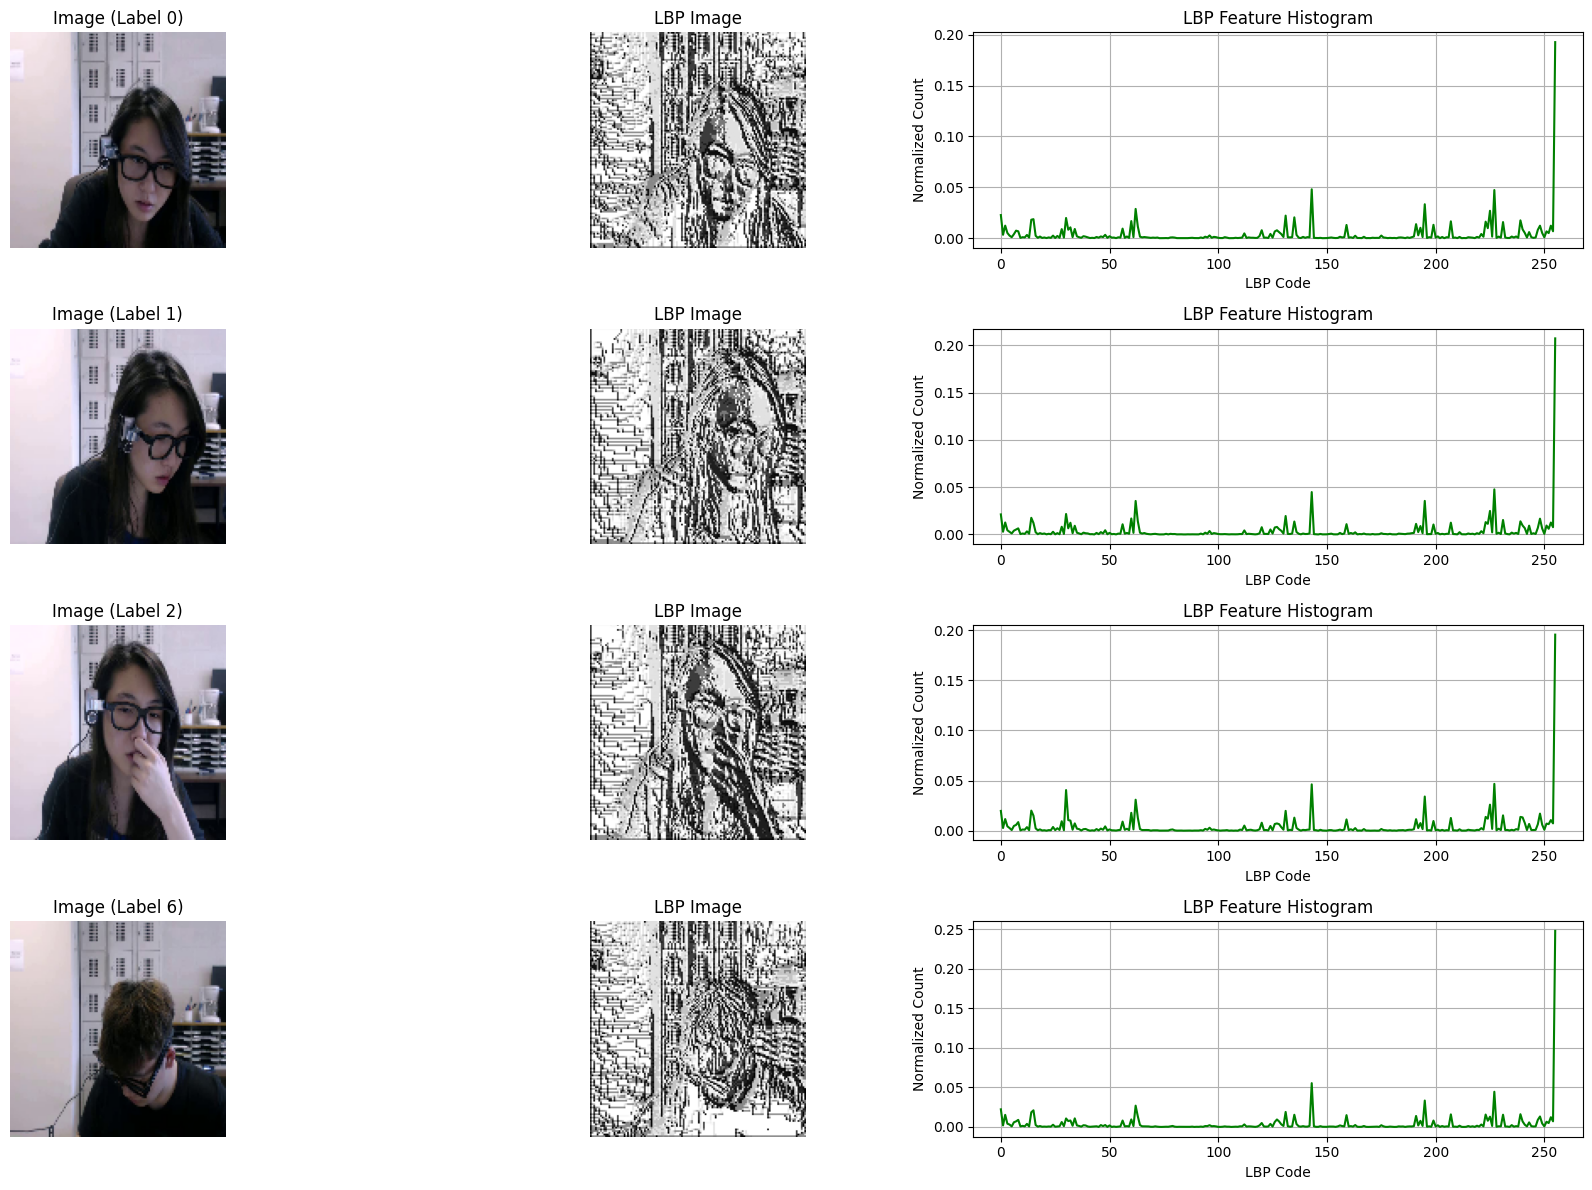

In [22]:
ImagePath = {
    0: "frame_0000.jpg",
    1: "frame_0061.jpg",
    2: "frame_0002.jpg",
    6: "frame_0006.jpg" 
}

ResizeDim = (128, 128)

plt.figure(figsize=(18, 12))
for Index, (Label, Path) in enumerate(ImagePath.items()):
    Image = cv2.imread(Path)

    LBPHist, LBPImage = LBPExtractFeatures(Image, ResizeDim)

    plt.subplot(len(ImagePath), 3, Index * 3 + 1)
    plt.imshow(cv2.cvtColor(cv2.resize(Image, ResizeDim), cv2.COLOR_BGR2RGB))
    plt.title(f"Image (Label {Label})")
    plt.axis('off')

    plt.subplot(len(ImagePath), 3, Index * 3 + 2)
    plt.imshow(LBPImage, cmap='gray')
    plt.title("LBP Image")
    plt.axis('off')

    plt.subplot(len(ImagePath), 3, Index * 3 + 3)
    plt.plot(LBPHist, color='green')
    plt.title("LBP Feature Histogram")
    plt.xlabel("LBP Code")
    plt.ylabel("Normalized Count")
    plt.grid(True)

plt.tight_layout()
plt.show()

### Fungsi untuk memproses frame yang sudah di-split, mengekstrak fitur, dan menyimpannya.

In [ ]:
def ProcessExtractFeature(
        FramesRootFolder, 
        OutputMetadataPath, 
        OutputFeaturesPath):
    FeaturesList = []
    MetadataList = []

    ResizeDimManual = (64, 64)
    HOGResizeDim = (64, 128)
    HOGCell = 8
    HOGBin = 9
    LBPResizeDim = ResizeDimManual
    HistBin = 4
    HistResize = ResizeDimManual

    NumCellsY = HOGResizeDim[1] // HOGCell
    NumCellsX = HOGResizeDim[0] // HOGCell
    NumBlocksY = NumCellsY - 1
    NumBlocksX = NumCellsX - 1
    EXPECTED_HOG_FEATURE_LENGTH = NumBlocksY * NumBlocksX * HOGBin * 4

    SubjectFolder = os.listdir(FramesRootFolder)
    for SubjectName in SubjectFolder:
        SubjectPath = os.path.join(FramesRootFolder, SubjectName)
        SegmentFolder = os.listdir(SubjectPath)
        for SegmentName in SegmentFolder:
            Parts = SegmentName.split('_')
            Label = int(Parts[-1])
            StartTime = int(Parts[1])
            EndTime = int(Parts[2]) if len(Parts) > 3 else StartTime
            SegmentPath = os.path.join(SubjectPath, SegmentName)
            FrameFiles = sorted(os.listdir(SegmentPath))
            for FrameFile in FrameFiles:
                FramePath = os.path.join(SegmentPath, FrameFile)
                ImageBGR = cv2.imread(FramePath)

                hist = ExtractColorHistogram(ImageBGR, bins_per_channel=HistBin,
                                               resize_dim=HistResize)
                hog = ExtractHOGFeatures(ImageBGR, resize_dim=HOGResizeDim,
                                           CellSize=HOGCell, BinSize=HOGBin)
                if hog.size != EXPECTED_HOG_FEATURE_LENGTH:
                    temp = np.zeros(EXPECTED_HOG_FEATURE_LENGTH)
                    temp[:min(len(hog), EXPECTED_HOG_FEATURE_LENGTH)] = hog[:min(len(hog), EXPECTED_HOG_FEATURE_LENGTH)]
                    hog = temp

                lbp = LBPExtractFeatures(ImageBGR, resize_dim=LBPResizeDim)
                CombinedFeature = np.hstack((hist, hog, lbp))

                FeaturesList.append(CombinedFeature)
                MetadataList.append({
                    'FramePath': FramePath,
                    'subject': SubjectName,
                    'segment_folder': SegmentName,
                    'parsed_start_time': StartTime,
                    'parsed_end_time': EndTime,
                    'label': Label
                })

    FeaturesArray = np.array(FeaturesList)
    MetadataDF = pd.DataFrame(MetadataList)

    os.makedirs(os.path.dirname(OutputMetadataPath), exist_ok=True)
    np.save(OutputFeaturesPath, FeaturesArray)
    MetadataDF.to_csv(OutputMetadataPath, index=False)

In [ ]:
if __name__ == "__main__":
    BasePathSubject = "C:/Users/fbkby/Latihan/UASPCD/pcd" 
    OutputPathFrames = os.path.join(BasePathSubject, "Output_Frames_Split") 
    ExtractedFeaturesPath = os.path.join(BasePathSubject, "Hasil_Ekstraksi_Fitur")

    if not os.path.exists(OutputPathFrames): os.makedirs(OutputPathFrames)
    if not os.path.exists(ExtractedFeaturesPath): os.makedirs(ExtractedFeaturesPath)

    OutputMetadata = os.path.join(ExtractedFeaturesPath, "metadata_fitur_lengkap.csv")
    OutputFeatures = os.path.join(ExtractedFeaturesPath, "fitur_array_lengkap.npy")

    LABEL_NON_CHEATING = 0 
    MAX_NON_CHEATING_PER_SUBJECT = 1000 
    SAMPLING_INTERVAL_NC_SEC = 5 

    SplittingSucces = SplitToFrame(
        BasePathSubject, 
        OutputPathFrames,
        NonCheatingLabel=LABEL_NON_CHEATING,
        MaxFramePerSubject=MAX_NON_CHEATING_PER_SUBJECT,
        IntervalSampling=SAMPLING_INTERVAL_NC_SEC
    )
    
    FeatureExtractionSucces = ProcessExtractFeature(
        FramesRootDir=OutputPathFrames,
        OutputMetadataPath=OutputMetadata,
        OutputFeaturesPath=OutputFeatures
    )

In [ ]:
FeaturesPath = "C:/Users/fbkby/Latihan/UASPCD/pcd/Hasil_Ekstraksi_Fitur/fitur_array_lengkap.npy"
MetadataPath = "C:/Users/fbkby/Latihan/UASPCD/pcd/Hasil_Ekstraksi_Fitur/metadata_fitur_lengkap.csv"

X = np.load(FeaturesPath)
MetadataDF = pd.read_csv(MetadataPath)
y = MetadataDF['label'].values

print(f"Bentuk array fitur (X): {X.shape}")
print(f"Bentuk array label (y): {y.shape}")
print(f"\nContoh beberapa label (y[:10]): {y[:10]}")
print(f"\nDistribusi kelas dalam metadata:\n{MetadataDF['label'].value_counts().sort_index()}")

LabelSorted = sorted(MetadataDF['label'].unique()) 
print(f"\nLabel kelas numerik yang terdeteksi (sorted): {LabelSorted}")

ClassLabel = {
    0: "Non-Cheating", 
    1: "Tipe 1 (Catatan)",
    2: "Tipe 2 (Berbicara)",
    6: "Tipe 6 (Nunduk)"
}

ClassReport = [ClassLabel.get(Label, f"Unknown Label {Label}") for Label in LabelSorted]
print(f"Nama kelas yang akan digunakan untuk laporan: {ClassReport}")

Bentuk array fitur (X): (93757, 4100)
Bentuk array label (y): (93757,)

Contoh beberapa label (y[:10]): [0 0 0 0 0 0 0 0 0 0]

Distribusi kelas dalam metadata:
label
0     1802
1    10103
2    81751
6      101
Name: count, dtype: int64

Label kelas numerik yang terdeteksi (sorted): [0, 1, 2, 6]
Nama kelas yang akan digunakan untuk laporan: ['Non-Cheating', 'Tipe 1 (Catatan)', 'Tipe 2 (Berbicara)', 'Tipe 6 (Nunduk)']


### Normalisasi data

In [ ]:
Scaler = StandardScaler()
X_scaled = Scaler.fit_transform(X)

print(f"\nBentuk array fitur setelah scaling (X_scaled): {X_scaled.shape}")
print(f"Contoh data fitur setelah scaling (baris pertama):\n{X_scaled[0, :10]}...")


Bentuk array fitur setelah scaling (X_scaled): (93757, 4100)
Contoh data fitur setelah scaling (baris pertama):
[-1.12977492  1.07383708 -0.05531065  1.44054711  0.09979995 -0.17045004
 -0.54645994 -0.08743052  0.31476477  0.36530977]...


### Train test split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.20, random_state=42, stratify=y)

print(f"\nUkuran X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"Ukuran X_test: {X_test.shape}, y_test: {y_test.shape}")

print(f"\nDistribusi kelas di y_train:\n{pd.Series(y_train).value_counts().sort_index()}")
print(f"Distribusi kelas di y_test:\n{pd.Series(y_test).value_counts().sort_index()}")


Ukuran X_train: (75005, 4100), y_train: (75005,)
Ukuran X_test: (18752, 4100), y_test: (18752,)

Distribusi kelas di y_train:
0     1442
1     8082
2    65400
6       81
Name: count, dtype: int64
Distribusi kelas di y_test:
0      360
1     2021
2    16351
6       20
Name: count, dtype: int64


### Mengevaluasi model dan menampilkan metrik serta confusion matrix.

In [ ]:
def ModelEvaluate(ModelName, y_true, y_pred, ClassLabelsReport, LabelsSorted):
    Accuracy = accuracy_score(y_true, y_pred)
    Report = classification_report(y_true, y_pred, labels=LabelsSorted, target_names=ClassLabelsReport, zero_division=0)
    ConfusionMatrix = confusion_matrix(y_true, y_pred, labels=LabelsSorted)

    print(f"--- Hasil Evaluasi untuk Model: {ModelName} ---")
    print(f"Akurasi: {Accuracy:.4f}")
    print(Report)
    plt.figure(figsize=(len(ClassLabelsReport)*2, len(ClassLabelsReport)*1.5)) 
    sns.heatmap(ConfusionMatrix, annot=True, fmt='d', cmap='Blues', 
                xticklabels=ClassLabelsReport, yticklabels=ClassLabelsReport)

### Distribusi sebelum dan sesudah dilakukan under sampling

In [ ]:
print("\nDistribusi kelas sebelum RandomUnderSampler (y_train asli):", Counter(y_train))

rus = RandomUnderSampler(random_state=42, sampling_strategy='auto') 

X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)

print("Distribusi kelas setelah RandomUnderSampler (y_train_rus):", Counter(y_train_rus))
print(f"Ukuran X_train setelah RandomUnderSampler: {X_train_rus.shape}")


Distribusi kelas sebelum RandomUnderSampler (y_train asli): Counter({2: 65400, 1: 8082, 0: 1442, 6: 81})
Distribusi kelas setelah RandomUnderSampler (y_train_rus): Counter({0: 81, 1: 81, 2: 81, 6: 81})
Ukuran X_train setelah RandomUnderSampler: (324, 4100)


### Random Forest


Melatih Random Forest dengan data RandomUnderSampler...

Hasil Evaluasi Random Forest dengan data RandomUnderSampler:
--- Hasil Evaluasi untuk Model: Random Forest (RandomUnderSampler) ---
Akurasi: 0.6241
                    precision    recall  f1-score   support

      Non-Cheating       0.05      0.70      0.10       360
  Tipe 1 (Catatan)       0.42      0.71      0.53      2021
Tipe 2 (Berbicara)       0.95      0.61      0.74     16351
   Tipe 6 (Nunduk)       0.49      1.00      0.66        20

          accuracy                           0.62     18752
         macro avg       0.48      0.76      0.51     18752
      weighted avg       0.88      0.62      0.71     18752



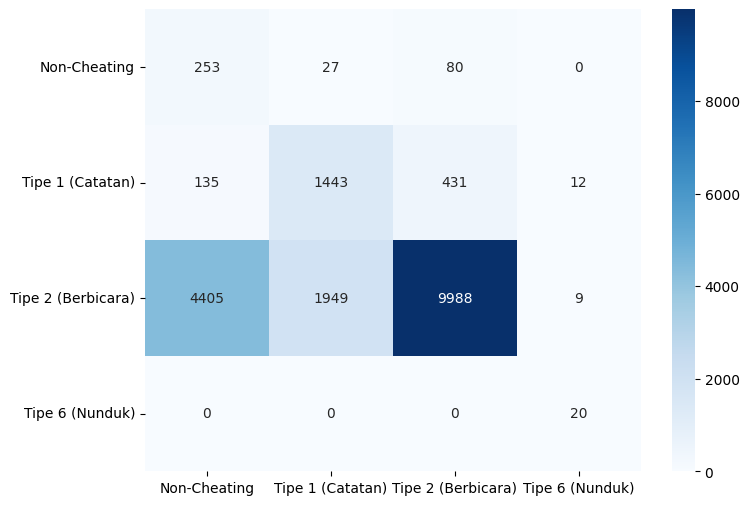

In [ ]:
print("\nMelatih Random Forest dengan data RandomUnderSampler...")
rf_model_rus = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_model_rus.fit(X_train_rus, y_train_rus)

y_pred_rf_rus = rf_model_rus.predict(X_test)

print("\nHasil Evaluasi Random Forest dengan data RandomUnderSampler:")
ModelEvaluate("Random Forest (RandomUnderSampler)", y_test, y_pred_rf_rus, ClassReport, LabelSorted)

### Gradient boosting


Melatih Model: Gradient Boosting Classifier dengan data RandomUnderSampler...

Hasil Evaluasi Gradient Boosting Classifier dengan data RandomUnderSampler:
--- Hasil Evaluasi untuk Model: Gradient Boosting (RandomUnderSampler) ---
Akurasi: 0.6567
                    precision    recall  f1-score   support

      Non-Cheating       0.06      0.62      0.10       360
  Tipe 1 (Catatan)       0.40      0.70      0.51      2021
Tipe 2 (Berbicara)       0.95      0.65      0.77     16351
   Tipe 6 (Nunduk)       0.20      1.00      0.34        20

          accuracy                           0.66     18752
         macro avg       0.40      0.74      0.43     18752
      weighted avg       0.87      0.66      0.73     18752



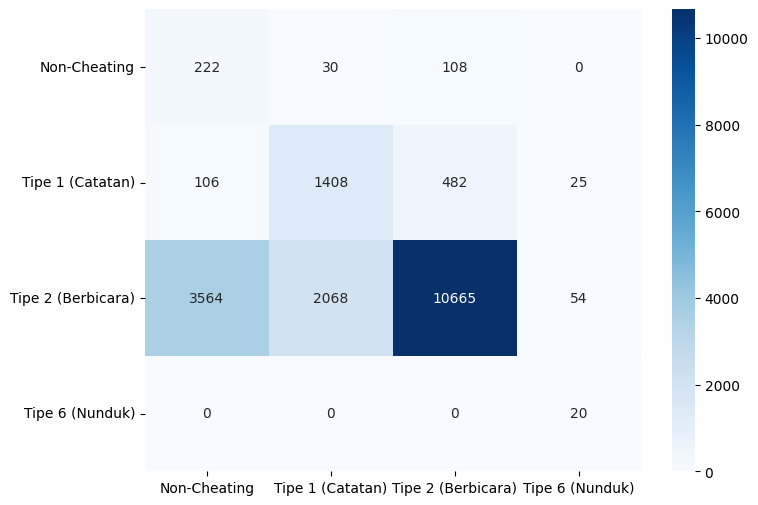

In [ ]:
print("\nMelatih Model: Gradient Boosting Classifier dengan data RandomUnderSampler...")

GBRus = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

GBRus.fit(X_train_rus, y_train_rus)

y_pred_gb_rus = GBRus.predict(X_test)

print("\nHasil Evaluasi Gradient Boosting Classifier dengan data RandomUnderSampler:")
ModelEvaluate("Gradient Boosting (RandomUnderSampler)", y_test, y_pred_gb_rus, ClassReport, LabelSorted)


Memulai GridSearchCV untuk Random Forest...
Fitting 3 folds for each of 162 candidates, totalling 486 fits
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.5s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.5s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.5s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   1.0s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   1.2s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   1.4s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   1.7s
[CV] END max_depth=10, max_features=sqrt, min_sample

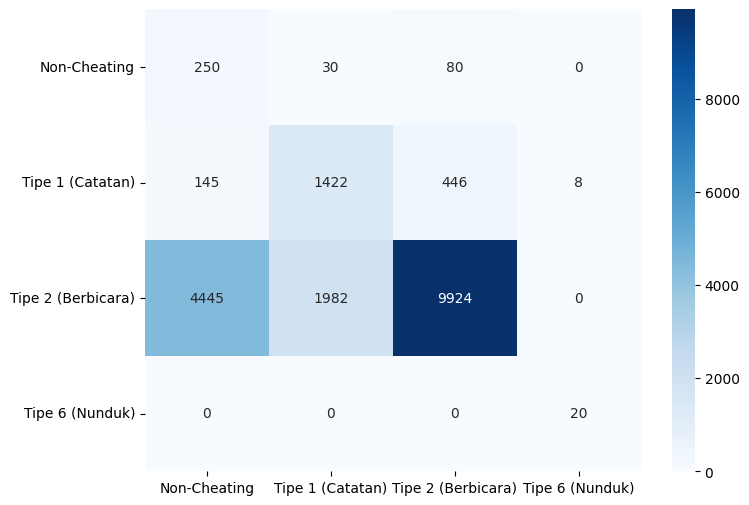

In [ ]:
param_grid = {
    'n_estimators': [100, 200, 300],    
    'max_depth': [10, 20, None],          
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']  
}

grid_search_rf = GridSearchCV(estimator=RandomForestClassifier(random_state=42, n_jobs=-1), 
                              param_grid=param_grid, 
                              cv=3, 
                              scoring='f1_macro',
                              verbose=2) 
print("\nMemulai GridSearchCV untuk Random Forest...")
grid_search_rf.fit(X_train_rus, y_train_rus)

print("\nParameter terbaik ditemukan oleh GridSearchCV:")
print(grid_search_rf.best_params_)

best_rf_model = grid_search_rf.best_estimator_

print("\nHasil Evaluasi Random Forest dengan parameter terbaik (GridSearchCV):")
y_pred_best_rf = best_rf_model.predict(X_test)
ModelEvaluate("Random Forest (Tuned - GridSearchCV)", y_test, y_pred_best_rf, ClassReport, LabelSorted)

Distribusi y_train sebelum RUS: Counter({2: 65400, 1: 8082, 0: 1442, 6: 81})
Strategi Undersampling Kustom: {1: 8082, 2: 8000, 6: 81}
Distribusi y_train setelah RUS kustom: Counter({1: 8082, 2: 8000, 0: 1442, 6: 81})
Ukuran X_train setelah RUS kustom: (17605, 4100)

Melatih Random Forest dengan data RUS kustom...

Hasil Evaluasi Random Forest dengan data RUS kustom:
--- Hasil Evaluasi untuk Model: Random Forest (RUS Kustom) ---
Akurasi: 0.8940
                    precision    recall  f1-score   support

      Non-Cheating       0.62      0.43      0.51       360
  Tipe 1 (Catatan)       0.55      0.92      0.69      2021
Tipe 2 (Berbicara)       0.98      0.90      0.94     16351
   Tipe 6 (Nunduk)       1.00      0.90      0.95        20

          accuracy                           0.89     18752
         macro avg       0.79      0.79      0.77     18752
      weighted avg       0.92      0.89      0.90     18752



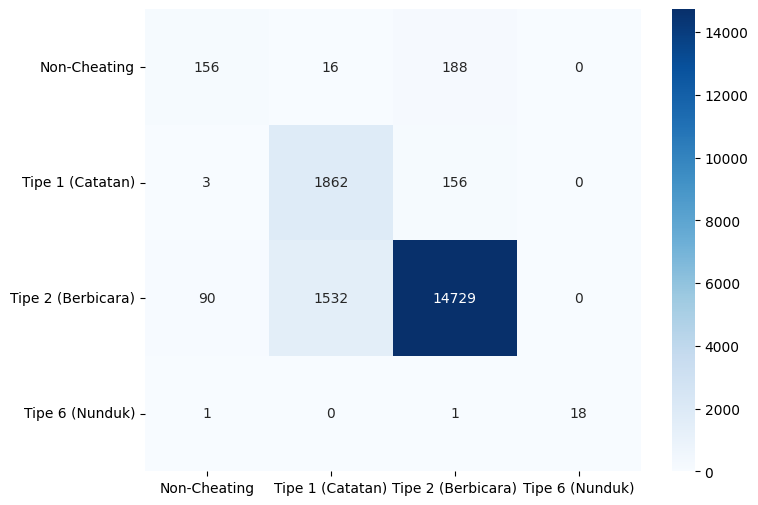

In [ ]:
print("Distribusi y_train sebelum RUS:", Counter(y_train))

CountsYTrain = Counter(y_train)
Label6 = 6 
Label1 = 1
Label2 = 2
Label0 = 0

NSamplesLabel6 = CountsYTrain.get(Label6, 0)
NSamplesLabel1 = CountsYTrain.get(Label1, 0)

TargetSamplesLabel1 = NSamplesLabel1 
TargetSamplesLabel2 = max(NSamplesLabel6 * 15, min(CountsYTrain.get(Label2,0), 8000))  

CustomRUS = {
    Label1: TargetSamplesLabel1,
    Label2: TargetSamplesLabel2,
    Label6: NSamplesLabel6 
}

for KClass in CustomRUS:
    if CustomRUS[KClass] > CountsYTrain.get(KClass, 0):
        CustomRUS[KClass] = CountsYTrain.get(KClass, 0)

print(f"Strategi Undersampling Kustom: {CustomRUS}")

RUSCustom = RandomUnderSampler(random_state=42, sampling_strategy=CustomRUS)
X_train_rus_custom, y_train_rus_custom = RUSCustom.fit_resample(X_train, y_train)

print("Distribusi y_train setelah RUS kustom:", Counter(y_train_rus_custom))
print(f"Ukuran X_train setelah RUS kustom: {X_train_rus_custom.shape}")

print("\nMelatih Random Forest dengan data RUS kustom...")
RDRUSCustom = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
RDRUSCustom.fit(X_train_rus_custom, y_train_rus_custom)
y_pred_rf_rus_custom = RDRUSCustom.predict(X_test) 

print("\nHasil Evaluasi Random Forest dengan data RUS kustom:")
ModelEvaluate("Random Forest (RUS Kustom)", y_test, y_pred_rf_rus_custom, ClassReport, LabelSorted)

In [ ]:
ModelTerbaik = RUSCustom

PathModel = 'model_deteksi_cheating_rf.joblib' 

joblib.dump(ModelTerbaik, PathModel)
print(f"Model telah disimpan di: {PathModel}")

PathScaler = 'scaler_fitur.joblib'
joblib.dump(Scaler, PathScaler) 
print(f"Scaler telah disimpan di: {PathScaler}")

Model telah disimpan di: model_deteksi_cheating_rf.joblib
Scaler telah disimpan di: scaler_fitur.joblib


sumber input text : https://www.geeksforgeeks.org/python-opencv-cv2-puttext-method/

In [ ]:
PATH_MODEL_TERSIMPAN = 'model_deteksi_cheating_rf.joblib'
PATH_SCALER_TERSIMPAN = 'scaler_fitur.joblib'

LoadModel = joblib.load(PATH_MODEL_TERSIMPAN)
LoadScaler = joblib.load(PATH_SCALER_TERSIMPAN)

COMMON_RESIZE_DIM_MANUAL = (64, 64)
HOG_MANUAL_RESIZE_DIM = (64, 128)
HOG_CELL_SIZE = 8
HOG_BIN_SIZE = 9
COLOR_HIST_BINS_MANUAL = 4

CLASS_NAMES_MAPPING = {
    0: "Non-Cheating",
    1: "Tipe 1 (Menyontek dari catatan/buku)",
    2: "Tipe 2 (Berbicara dengan orang lain)",
    6: "Tipe 6 (Nunduk mencurigakan)"
}

def DetectCheating(VideoPath, Model, Scaler, OutputFolder="screenshots_deteksi"):
    if not os.path.exists(OutputFolder):
        os.makedirs(OutputFolder)

    cap = cv2.VideoCapture(VideoPath)
    if not cap.isOpened():
        return

    Fps = cap.get(cv2.CAP_PROP_FPS)
    FrameCount = 0

    LastDetectiontime = -10
    MinInterval = 5

    while True:
        ret, frame_bgr = cap.read()
        if not ret:
            break

        FrameCount += 1
        CurrentSec = FrameCount / Fps

        hist_m = ExtractColorHistogram(frame_bgr,
                                         bins_per_channel=COLOR_HIST_BINS_MANUAL,
                                         resize_dim=COMMON_RESIZE_DIM_MANUAL)
        hog_m = ExtractHOGFeatures(frame_bgr,
                                     resize_dim=HOG_MANUAL_RESIZE_DIM,
                                     cell_size=HOG_CELL_SIZE,
                                     bin_size=HOG_BIN_SIZE)
        lbp_m = LBPExtractFeatures(frame_bgr,
                                     resize_dim=COMMON_RESIZE_DIM_MANUAL)

        FeaturesFrame = np.hstack((hist_m, hog_m, lbp_m))
        ReshapedFeaturesFrame = FeaturesFrame.reshape(1, -1)
        ScaledFeaturesFrame = Scaler.transform(ReshapedFeaturesFrame)

        Prediction = Model.predict(ScaledFeaturesFrame)
        PredictedLabel = Prediction[0]

        if PredictedLabel in CLASS_NAMES_MAPPING:
            if (CurrentSec - LastDetectiontime) >= MinInterval:
                ReadableLabel = CLASS_NAMES_MAPPING[PredictedLabel]
                Timestamp = f"{int(CurrentSec // 60):02d}m{int(CurrentSec % 60):02d}s"

                print(f"Video: {os.path.basename(VideoPath)}, Waktu: {Timestamp}, Tipe: {ReadableLabel}")

                Now = datetime.datetime.now()
                ScreenshotName = f"CHEAT_{os.path.basename(VideoPath).split('.')[0]}{Now.strftime('%Y%m%d%H%M%S%f')}.jpg"
                ScreenshotPath = os.path.join(OutputFolder, ScreenshotName)

                cv2.imwrite(ScreenshotPath, frame_bgr)

                ImageToLabel = cv2.imread(ScreenshotPath)
                LabelText = f"{ReadableLabel} @ {Timestamp}"
                TextPosition = (10, 30)
                Font = cv2.FONT_HERSHEY_SIMPLEX
                FontScale = 0.7
                FontColor = (0, 0, 255)
                LineType = 2

                (TextWidth, TextHeight), _ = cv2.getTextSize(LabelText, Font, FontScale, LineType)
                cv2.rectangle(ImageToLabel, (TextPosition[0] - 5, TextPosition[1] - TextHeight - 5),
                              (TextPosition[0] + TextWidth + 5, TextPosition[1] + 5), (255, 255, 255), -1)
                cv2.putText(ImageToLabel, LabelText, TextPosition, Font, FontScale, FontColor, LineType)

                cv2.imwrite(ScreenshotPath, ImageToLabel)
                LastDetectiontime = CurrentSec

    cap.release()

Model dan Scaler berhasil dimuat.


In [ ]:
if __name__ == '__main__':
    PATH_VIDEO_BARU = "C:/latihan/.vscode/semester 4/pcd/project/subject15/WIN_20250603_21_00_19_Pro.mp4" 
    FOLDER_SCREENSHOT = "hasil_deteksi_cheating_fabyan"    
    DetectCheating(PATH_VIDEO_BARU, LoadModel, LoadScaler, FOLDER_SCREENSHOT)

Video: WIN_20250603_21_00_19_Pro.mp4, Waktu: 00m00s, Tipe: Tipe 2 (Berbicara dengan orang lain)
Video: WIN_20250603_21_00_19_Pro.mp4, Waktu: 00m05s, Tipe: Tipe 2 (Berbicara dengan orang lain)
Video: WIN_20250603_21_00_19_Pro.mp4, Waktu: 00m10s, Tipe: Tipe 2 (Berbicara dengan orang lain)
Video: WIN_20250603_21_00_19_Pro.mp4, Waktu: 00m15s, Tipe: Tipe 2 (Berbicara dengan orang lain)
Video: WIN_20250603_21_00_19_Pro.mp4, Waktu: 00m20s, Tipe: Tipe 2 (Berbicara dengan orang lain)
Video: WIN_20250603_21_00_19_Pro.mp4, Waktu: 00m25s, Tipe: Tipe 2 (Berbicara dengan orang lain)
Video: WIN_20250603_21_00_19_Pro.mp4, Waktu: 00m30s, Tipe: Tipe 2 (Berbicara dengan orang lain)
Video: WIN_20250603_21_00_19_Pro.mp4, Waktu: 00m35s, Tipe: Tipe 2 (Berbicara dengan orang lain)
Video: WIN_20250603_21_00_19_Pro.mp4, Waktu: 00m40s, Tipe: Tipe 2 (Berbicara dengan orang lain)
Video: WIN_20250603_21_00_19_Pro.mp4, Waktu: 00m45s, Tipe: Tipe 2 (Berbicara dengan orang lain)
Video: WIN_20250603_21_00_19_Pro.mp4, Wa

### Implementasi HOG secara menaual dengan contoh data piksel dummy 5x5

In [2]:
import numpy as np

image = np.array([
    [100, 120, 130, 110, 90],
    [110, 140, 150, 130, 100],
    [120, 150, 180, 140, 110],
    [100, 130, 140, 120, 100],
    [90, 110, 120, 100, 80]
])

print("Matriks Piksel 5x5:")
print(image)

sobel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
sobel_y = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])

gx = np.zeros((5, 5))
gy = np.zeros((5, 5))

for i in range(1, 4):
    for j in range(1, 4):
        gx[i, j] = np.sum(image[i-1:i+2, j-1:j+2] * sobel_x)
        gy[i, j] = np.sum(image[i-1:i+2, j-1:j+2] * sobel_y)

print("\nGradien Gx:")
print(gx)
print("\nGradien Gy:")
print(gy)

magnitude = np.sqrt(gx**2 + gy**2)
orientation = np.arctan2(gy, gx) * (180 / np.pi)
orientation = np.where(orientation < 0, orientation + 180, orientation)

print("\nMagnitude:")
print(magnitude)
print("\nOrientasi (derajat):")
print(orientation)

num_bins = 9
bin_size = 180 / num_bins 
histogram = np.zeros(num_bins)

for i in range(1, 4):
    for j in range(1, 4):
        bin_idx = int(orientation[i, j] // bin_size)  
        histogram[bin_idx] += magnitude[i, j] 

print("\nHistogram (9 bin):")
for i in range(num_bins):
    print(f"Bin {i} ({i*bin_size:.1f}-{((i+1)*bin_size):.1f} derajat): {histogram[i]:.2f}")

bins = [i * bin_size for i in range(num_bins)]

Matriks Piksel 5x5:
[[100 120 130 110  90]
 [110 140 150 130 100]
 [120 150 180 140 110]
 [100 130 140 120 100]
 [ 90 110 120 100  80]]

Gradien Gx:
[[   0.    0.    0.    0.    0.]
 [   0.  170.  -40. -210.    0.]
 [   0.  200.  -40. -230.    0.]
 [   0.  170.  -40. -190.    0.]
 [   0.    0.    0.    0.    0.]]

Gradien Gy:
[[   0.    0.    0.    0.    0.]
 [   0.  130.  160.  130.    0.]
 [   0.  -40.  -40.  -30.    0.]
 [   0. -170. -200. -170.    0.]
 [   0.    0.    0.    0.    0.]]

Magnitude:
[[  0.           0.           0.           0.           0.        ]
 [  0.         214.00934559 164.92422502 246.9817807    0.        ]
 [  0.         203.96078054  56.56854249 231.94827009   0.        ]
 [  0.         240.4163056  203.96078054 254.95097568   0.        ]
 [  0.           0.           0.           0.           0.        ]]

Orientasi (derajat):
[[  0.           0.           0.           0.           0.        ]
 [  0.          37.40535663 104.03624347 148.24051992   0.     